# Art Generation With Neural Style Transfer

In this project, we will implement Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

Most of the algorithms optimize a cost function to get a set of parameter values. With Neural Style Transfer, you'll get to optimize a cost function to get pixel values.

<a name='1'></a>
## 1 - Packages

Importing the necessary packages and dependencies you will need to perform Neural Style Transfer.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

<a name='2'></a>
## 2 - Problem Statement

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

We are going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's get started!

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

We will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 


In [2]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)

Next, we will be building the Neural Style Transfer (NST) algorithm in three steps:

- First, you will build the content cost function $J_{content}(C,G)$
- Second, you will build the style cost function $J_{style}(S,G)$
- Finally, you'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Make Generated Image G Match the Content of Image C

One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>.


In this running example, the content image C will be the picture of the Louvre Museum in Paris. 

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


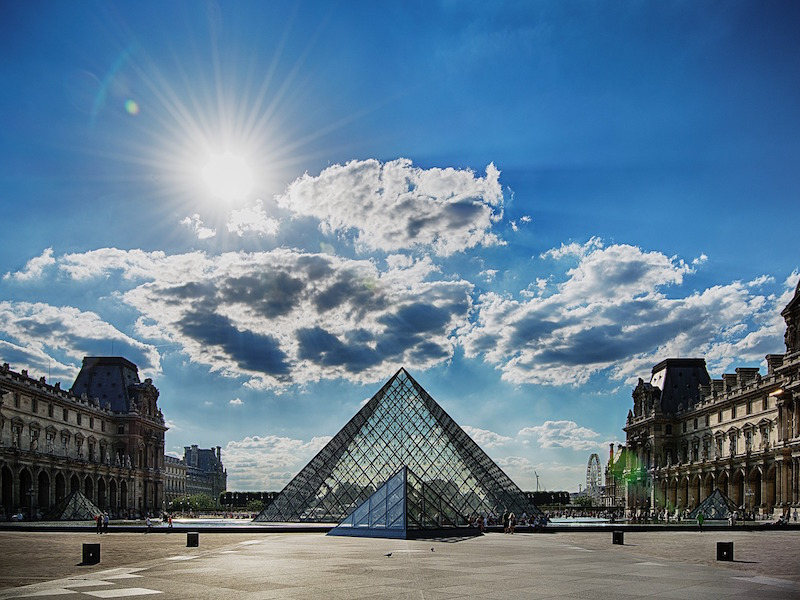

In [3]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when we need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

<a name='ex-1'></a>
### Compute_content_cost

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
2. Unroll `a_C` and `a_G` as explained in the picture above
3. Compute the content cost:
    
    


In [4]:

def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow 
    J_content =  tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/(4 * n_H * n_W * n_C)
    
    return J_content

In [5]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

print("J_content = " + str(J_content))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


<a name='4-2'></a>
### 4.2 - Computing the Style Cost


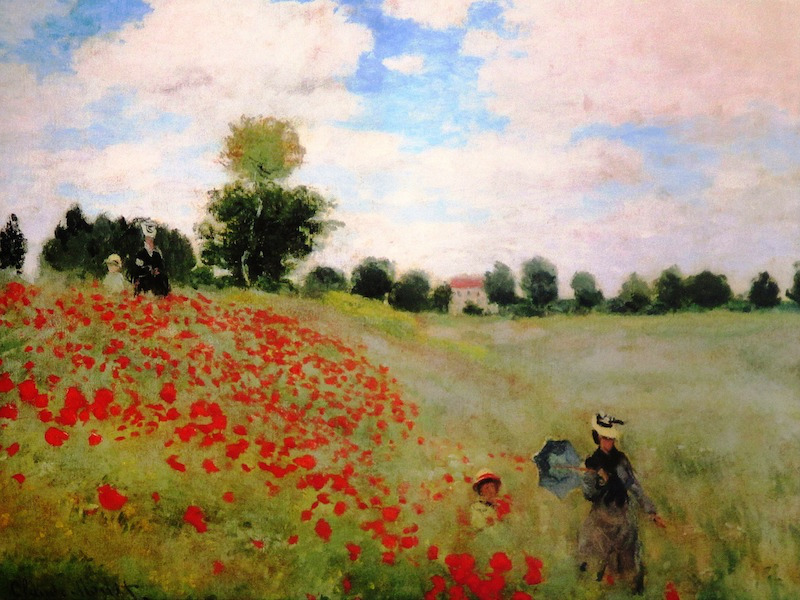

In [6]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now let's define a "style" cost function $J_{style}(S,G)$!

<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity,  $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute Gram matrix $G_{gram}$
We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

<a name='ex-2'></a>
### Gram_matrix
   * The formula is: The gram matrix of A is $G_A = AA^T$. 


In [7]:
def gram_matrix(A):
    
    GA = tf.linalg.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA))

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

Our next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* We will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.


<a name='ex-3'></a>
### Compute_layer_style_cost
Compute the style cost for a single layer. 

The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above 
3. Compute the Style matrix of the images S and G.  
4. Compute the Style cost:

In [9]:
def compute_layer_style_cost(a_S, a_G):
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) 
    a_S = tf.reshape(tf.transpose(a_S, perm=[0,3,1,2]), shape=[n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), shape=[n_C, n_H * n_W])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4 * n_C**2 * (n_H * n_W)**2)
    
    return J_style_layer

In [10]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer_SG))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)


J_style_layer = tf.Tensor(14.017808, shape=(), dtype=float32)


<a name='4-2-3'></a>
#### 4.2.3 Style Weights

Start by listing the layer names:

In [11]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
vgg.get_layer('block5_conv4').output

<tf.Tensor 'block5_conv4/Relu:0' shape=(None, 25, 25, 512) dtype=float32>

Choosing layers to represent the style of the image and assign style costs:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

We can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


<a name='ex-4'></a>
### Compute_style_cost
Compute style cost

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)


In [14]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other.  

   



<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='ex-5'></a>
### Total_cost

Implement the total cost function which includes both the content cost and the style cost. 

In [15]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
 
    J = alpha*J_content + beta*J_style

    return J

In [16]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))



J = tf.Tensor(32.9832, shape=(), dtype=float32)


<a name='5'></a>
## 5 - Solving the Optimization Problem

Finally, we get to put everything together to implement Neural Style Transfer!


Here's what our program be able to do:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

Here are the individual steps in detail.

<a id='part(4)'></a>

<a name='5-1'></a>
### 5.1 Load the Content Image
To load, reshape, and normalize out "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


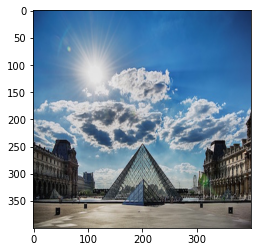

In [17]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image
Now load, reshape and normalize out "style" image (Claude Monet's painting):

(1, 400, 400, 3)


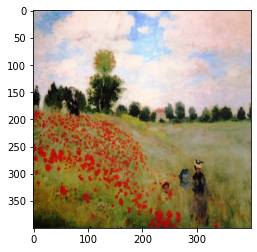

In [18]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
Now, we get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


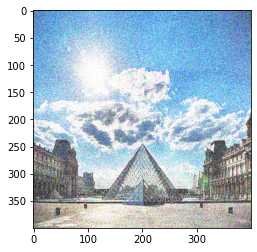

In [19]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model
Next, as explained in [part(2)](#part(2)), define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [20]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [21]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [22]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

<a name='5-5'></a>
### 5.5 - Compute Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Compute Content Cost

We have built the model, and now to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `block5_conv4` to compute the content cost. The code below does the following:

1. Set a_C to be the tensor giving the hidden layer activation for layer "block5_conv4".
2. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
3. Compute the content cost using a_C and a_G.

In [23]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.008070097, shape=(), dtype=float32)


<a name='5-5-2'></a>
#### 5.5.2 - Compute Style Cost

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS`.

In [24]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(598.82825, shape=(), dtype=float32)


Below are the utils that we will need to display the images generated by the style transfer model.

In [25]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
### Train_step 

Implementing the train_step() function for transfer learning


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, 10, 40)  
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
 
    return J

In [27]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)


J2 = train_step(generated_image)
print(J2)


tf.Tensor(10221.222, shape=(), dtype=float32)
tf.Tensor(6081.287, shape=(), dtype=float32)


<a name='5-6'></a>
### 5.6 - Train the Model


Epoch 0 


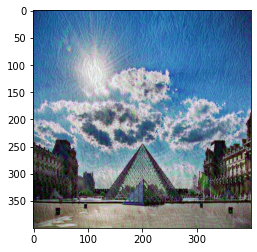

Epoch 50 


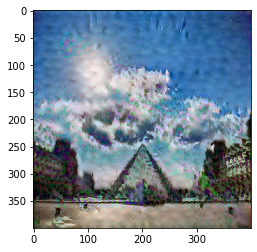

Epoch 100 


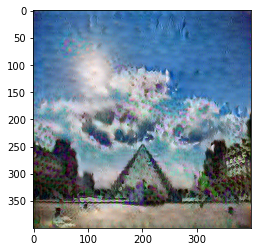

Epoch 150 


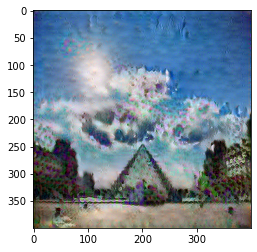

Epoch 200 


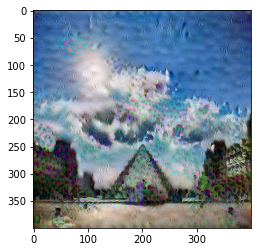

Epoch 250 


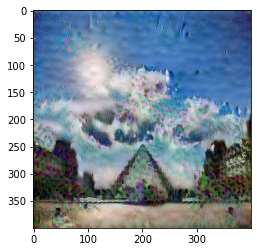

In [28]:
# Show the generated image at some epochs
epochs = 251
for i in range(epochs):
    train_step(generated_image)
    if i % 50 == 0:
        print(f"Epoch {i} ")
    if i % 50 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

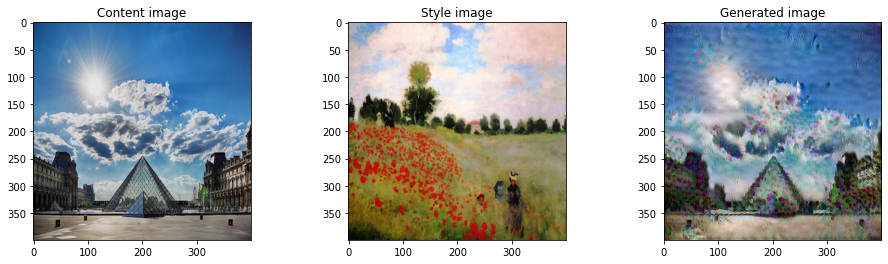

In [29]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
